# Project: Wrangling and Analyze Data

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#gather">Gathering Data</a></li>
<li><a href="#assess">Assessing Data</a></li>
<li><a href="#clean">Cleaning Data</a></li>
<li><a href="#store">Storing Data</a></li>
<li><a href="#analyze">Analyzing and Visualizing Data</a></li>
<li><a href="#conclusions">Conclusions</a></li>
</ul>

<a id='intro'></a>
## Introduction

In this project, we will wrangle WeRateDogs Twitter data to create interesting and trustworthy analyses and visualizations. Besides, we will be collecting three sources of data for this project which are, the first is Enhanced Twitter Archive: contains very basic tweet information. The second source is Additional Data via the Twitter API: we will gather each tweet's retweet count and favorite ("like") count. The last source is Image Predictions File: is present every image in the WeRateDogs Twitter archive through a neural network. 

Thereafter, we will gather them in the notebook, then assessing and cleaning for worthy analyses and visualizations.

<a id='gather'></a>
## Gathering Data

To get started, let's import our libraries.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import requests 
import matplotlib.pyplot as plt 
%matplotlib inline

import tweepy
from tweepy import OAuthHandler
import json
from timeit import default_timer as timer

In [2]:
import re
import os
from subprocess import check_output
from wordcloud import WordCloud, ImageColorGenerator
from PIL import Image
import locale

In [3]:
# style
sns.set_style("darkgrid")

1. By directly loading the WeRateDogs Twitter archive data (twitter_archive_enhanced.csv)

In [4]:
df_twitter_archive = pd.read_csv('twitter-archive-enhanced.csv')
df_twitter_archive.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


2. By using the Requests library to loading the tweet image prediction (image_predictions.tsv)

In [5]:
url = "https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv"
response = requests.get(url)

with open('image-predictions.tsv', mode='wb') as file:
    file.write(response.content)

df_image_predictions = pd.read_csv('image-predictions.tsv', sep='\t')

In [6]:
df_image_predictions.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


3. By using the Tweepy library to query additional data via the Twitter API (tweet _json.txt)

In [7]:
# Query Twitter API for each tweet in the Twitter archive and save JSON in a text file
# These are hidden to comply with Twitter's API terms and conditions
consumer_key = 'HIDDEN'
consumer_secret = 'HIDDEN'
access_token = 'HIDDEN'
access_secret = 'HIDDEN'

auth = OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)

api = tweepy.API(auth, wait_on_rate_limit=True)

In [8]:
# NOTE TO STUDENT WITH MOBILE VERIFICATION ISSUES:
# df_1 is a DataFrame with the twitter_archive_enhanced.csv file. You may have to
# change line 17 to match the name of your DataFrame with twitter_archive_enhanced.csv
# NOTE TO REVIEWER: this student had mobile verification issues so the following
# Twitter API code was sent to this student from a Udacity instructor
# Tweet IDs for which to gather additional data via Twitter's API
tweet_ids = df_twitter_archive.tweet_id.values
len(tweet_ids)

2356

In [9]:
# Query Twitter's API for JSON data for each tweet ID in the Twitter archive
count = 0
fails_dict = {}
start = timer()
# Save each tweet's returned JSON as a new line in a .txt file
with open('tweet-json.txt', 'w') as outfile:
    # This loop will likely take 20-30 minutes to run because of Twitter's rate limit
    for tweet_id in tweet_ids:
        count += 1
        print(str(count) + ": " + str(tweet_id))
        try:
            tweet = api.get_status(tweet_id, tweet_mode='extended')
            print("Success")
            json.dump(tweet._json, outfile)
            outfile.write('\n')
        except tweepy.TweepError as e:
            print("Fail")
            fails_dict[tweet_id] = e
            pass
end = timer()
print(end - start)
print(fails_dict)

'\ncount = 0\nfails_dict = {}\nstart = timer()\n# Save each tweet\'s returned JSON as a new line in a .txt file\nwith open(\'tweet-json.txt\', \'w\') as outfile:\n    # This loop will likely take 20-30 minutes to run because of Twitter\'s rate limit\n    for tweet_id in tweet_ids:\n        count += 1\n        print(str(count) + ": " + str(tweet_id))\n        try:\n            tweet = api.get_status(tweet_id, tweet_mode=\'extended\')\n            print("Success")\n            json.dump(tweet._json, outfile)\n            outfile.write(\'\n\')\n        except tweepy.TweepError as e:\n            print("Fail")\n            fails_dict[tweet_id] = e\n            pass\nend = timer()\nprint(end - start)\nprint(fails_dict)'

In [10]:
df3_list = []

with open('tweet-json.txt', 'r', encoding='utf8') as js_file:
    for i in js_file:
        data = json.loads(i)
        df3_list.append({'tweet_id': data['id'],
                        'favorites': data['favorite_count'],
                        'retweets': data['retweet_count'],
                        'user_followers': data['user']['followers_count'], 
                        'user_favourites': data['user']['favourites_count'],
                        'timestamp': data['created_at']})
df_tweet_data = pd.DataFrame(df3_list, columns=['tweet_id','timestamp','retweets','favorites','user_followers','user_favourites'])

In [11]:
df_tweet_data.head()

,tweet_id,timestamp,retweets,favorites,user_followers,user_favourites
0,892420643555336193,Tue Aug 01 16:23:56 +0000 2017,8853,39467,3200889,114031
1,892177421306343426,Tue Aug 01 00:17:27 +0000 2017,6514,33819,3200889,114031
2,891815181378084864,Mon Jul 31 00:18:03 +0000 2017,4328,25461,3200889,114031
3,891689557279858688,Sun Jul 30 15:58:51 +0000 2017,8964,42908,3200889,114031
4,891327558926688256,Sat Jul 29 16:00:24 +0000 2017,9774,41048,3200889,114031


<a id='assess'></a>
## Assessing Data
In this section, we will be detect and document at least 8 quality issues and at least 2 tidiness issue in this dataset. We will be use both visual assessment and programmatic assessment to assess the data.




### Visual Assessment

In [12]:
# Display the twitter_archive dataset for visual assessment.
df_twitter_archive

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2351,666049248165822465,NaN,NaN,2015-11-16 00:24:50 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a 1949 1st generation vulpix. Enj...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666049248...,5,10,None,None,None,None,None
2352,666044226329800704,NaN,NaN,2015-11-16 00:04:52 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a purebred Piers Morgan. Loves to Netf...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666044226...,6,10,a,None,None,None,None
2353,666033412701032449,NaN,NaN,2015-11-15 23:21:54 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here is a very happy pup. Big fan of well-main...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666033412...,9,10,a,None,None,None,None
2354,666029285002620928,NaN,NaN,2015-11-15 23:05:30 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a western brown Mitsubishi terrier. Up...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666029285...,7,10,a,None,None,None,None


In [13]:
# Display the image_predictions dataset for visual assessment.
df_image_predictions

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True
...,...,...,...,...,...,...,...,...,...,...,...,...
2070,891327558926688256,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,2,basset,0.555712,True,English_springer,0.225770,True,German_short-haired_pointer,0.175219,True
2071,891689557279858688,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,1,paper_towel,0.170278,False,Labrador_retriever,0.168086,True,spatula,0.040836,False
2072,891815181378084864,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,1,Chihuahua,0.716012,True,malamute,0.078253,True,kelpie,0.031379,True
2073,892177421306343426,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,1,Chihuahua,0.323581,True,Pekinese,0.090647,True,papillon,0.068957,True


In [14]:
# Display the tweet_data dataset for visual assessment.
df_tweet_data

,tweet_id,timestamp,retweets,favorites,user_followers,user_favourites
0,892420643555336193,Tue Aug 01 16:23:56 +0000 2017,8853,39467,3200889,114031
1,892177421306343426,Tue Aug 01 00:17:27 +0000 2017,6514,33819,3200889,114031
2,891815181378084864,Mon Jul 31 00:18:03 +0000 2017,4328,25461,3200889,114031
3,891689557279858688,Sun Jul 30 15:58:51 +0000 2017,8964,42908,3200889,114031
4,891327558926688256,Sat Jul 29 16:00:24 +0000 2017,9774,41048,3200889,114031
...,...,...,...,...,...,...
2349,666049248165822465,Mon Nov 16 00:24:50 +0000 2015,41,111,3201018,114031
2350,666044226329800704,Mon Nov 16 00:04:52 +0000 2015,147,311,3201018,114031
2351,666033412701032449,Sun Nov 15 23:21:54 +0000 2015,47,128,3201018,114031
2352,666029285002620928,Sun Nov 15 23:05:30 +0000 2015,48,132,3201018,114031


### Programmatic Assessment

<hr>

#### `df_twitter_archive` dataset assessment

In [15]:
# Display a concise summary of twitter_archive dataframe
df_twitter_archive.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2356 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2356 non-null   object 
 4   source                      2356 non-null   object 
 5   text                        2356 non-null   object 
 6   retweeted_status_id         181 non-null    float64
 7   retweeted_status_user_id    181 non-null    float64
 8   retweeted_status_timestamp  181 non-null    object 
 9   expanded_urls               2297 non-null   object 
 10  rating_numerator            2356 non-null   int64  
 11  rating_denominator          2356 non-null   int64  
 12  name                        2356 non-null   object 
 13  doggo                       2356 

In [16]:
# Random sample for twitter_archive dataset.
df_twitter_archive.sample(10)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
1542,689599056876867584,NaN,NaN,2016-01-20 00:03:21 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we see 33 dogs posing for a picture. All ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/689599056...,11,10,None,None,None,None,None
1461,694925794720792577,NaN,NaN,2016-02-03 16:49:55 +0000,"<a href=""http://vine.co"" rel=""nofollow"">Vine -...",Please only send in dogs. This t-rex is very s...,NaN,NaN,NaN,https://vine.co/v/iJvUqWQ166L,5,10,None,None,None,None,None
1264,709918798883774466,NaN,NaN,2016-03-16 01:46:45 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Watson. He's a Suzuki Tickleboop. Leader ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/709918798...,12,10,Watson,None,None,None,None
505,812781120811126785,NaN,NaN,2016-12-24 22:04:54 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Swagger. He's the Cleveland Browns amb...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/812781120...,10,10,Swagger,None,None,None,None
892,759447681597108224,NaN,NaN,2016-07-30 17:56:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Oakley. He has no idea what happened h...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/759447681...,11,10,Oakley,None,None,None,None
2204,668636665813057536,NaN,NaN,2015-11-23 03:46:18 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is an Irish Rigatoni terrier named Berta....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/668636665...,10,10,an,None,None,None,None
1613,685315239903100929,NaN,NaN,2016-01-08 04:21:00 +0000,"<a href=""http://twitter.com/download/iphone"" r...",I would like everyone to appreciate this pup's...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/685315239...,11,10,None,None,None,None,None
1875,675113801096802304,NaN,NaN,2015-12-11 00:44:07 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Zuzu. He just graduated college. Astute p...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/675113801...,10,10,Zuzu,None,None,pupper,None
1490,692901601640583168,NaN,NaN,2016-01-29 02:46:29 +0000,"<a href=""http://twitter.com/download/iphone"" r...","""Fuck the system"" 10/10 https://t.co/N0OADmCnVV",NaN,NaN,NaN,https://twitter.com/dog_rates/status/692901601...,10,10,None,None,None,None,None
195,855138241867124737,NaN,NaN,2017-04-20 19:16:59 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @frasercampbell_: oh my... what's that... b...,8.551225e+17,7.475543e+17,2017-04-20 18:14:33 +0000,https://twitter.com/frasercampbell_/status/855...,14,10,None,None,None,None,None


In [17]:
# Display a general statistics about the twitter_archive dataset
df_twitter_archive.describe()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,retweeted_status_id,retweeted_status_user_id,rating_numerator,rating_denominator
count,2.356000e+03,7.800000e+01,7.800000e+01,1.810000e+02,1.810000e+02,2356.000000,2356.000000
mean,7.427716e+17,7.455079e+17,2.014171e+16,7.720400e+17,1.241698e+16,13.126486,10.455433
std,6.856705e+16,7.582492e+16,1.252797e+17,6.236928e+16,9.599254e+16,45.876648,6.745237
min,6.660209e+17,6.658147e+17,1.185634e+07,6.661041e+17,7.832140e+05,0.000000,0.000000
25%,6.783989e+17,6.757419e+17,3.086374e+08,7.186315e+17,4.196984e+09,10.000000,10.000000
50%,7.196279e+17,7.038708e+17,4.196984e+09,7.804657e+17,4.196984e+09,11.000000,10.000000
75%,7.993373e+17,8.257804e+17,4.196984e+09,8.203146e+17,4.196984e+09,12.000000,10.000000
max,8.924206e+17,8.862664e+17,8.405479e+17,8.874740e+17,7.874618e+17,1776.000000,170.000000


In [18]:
# Check for any duplicate rows.
df_twitter_archive.tweet_id.duplicated().sum()

0

In [19]:
# Arrange the timestamp column.
df_twitter_archive.sort_values('timestamp')

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
2355,666020888022790149,NaN,NaN,2015-11-15 22:32:08 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a Japanese Irish Setter. Lost eye...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666020888...,8,10,None,None,None,None,None
2354,666029285002620928,NaN,NaN,2015-11-15 23:05:30 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a western brown Mitsubishi terrier. Up...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666029285...,7,10,a,None,None,None,None
2353,666033412701032449,NaN,NaN,2015-11-15 23:21:54 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here is a very happy pup. Big fan of well-main...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666033412...,9,10,a,None,None,None,None
2352,666044226329800704,NaN,NaN,2015-11-16 00:04:52 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a purebred Piers Morgan. Loves to Netf...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666044226...,6,10,a,None,None,None,None
2351,666049248165822465,NaN,NaN,2015-11-16 00:24:50 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a 1949 1st generation vulpix. Enj...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666049248...,5,10,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None


In [20]:
# Check missing values for expanded_urls column
df_twitter_archive[df_twitter_archive['expanded_urls'].isnull()]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
30,886267009285017600,8.862664e+17,2.281182e+09,2017-07-15 16:51:35 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@NonWhiteHat @MayhewMayhem omg hello tanner yo...,NaN,NaN,NaN,NaN,12,10,None,None,None,None,None
55,881633300179243008,8.816070e+17,4.738443e+07,2017-07-02 21:58:53 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@roushfenway These are good dogs but 17/10 is ...,NaN,NaN,NaN,NaN,17,10,None,None,None,None,None
64,879674319642796034,8.795538e+17,3.105441e+09,2017-06-27 12:14:36 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@RealKentMurphy 14/10 confirmed,NaN,NaN,NaN,NaN,14,10,None,None,None,None,None
113,870726314365509632,8.707262e+17,1.648776e+07,2017-06-02 19:38:25 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@ComplicitOwl @ShopWeRateDogs &gt;10/10 is res...,NaN,NaN,NaN,NaN,10,10,None,None,None,None,None
148,863427515083354112,8.634256e+17,7.759620e+07,2017-05-13 16:15:35 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@Jack_Septic_Eye I'd need a few more pics to p...,NaN,NaN,NaN,NaN,12,10,None,None,None,None,None
179,857214891891077121,8.571567e+17,1.806710e+08,2017-04-26 12:48:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@Marc_IRL pixelated af 12/10,NaN,NaN,NaN,NaN,12,10,None,None,None,None,None
185,856330835276025856,NaN,NaN,2017-04-24 02:15:55 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @Jenna_Marbles: @dog_rates Thanks for ratin...,8.563302e+17,66699013.0,2017-04-24 02:13:14 +0000,NaN,14,10,None,None,None,None,None
186,856288084350160898,8.562860e+17,2.792810e+08,2017-04-23 23:26:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@xianmcguire @Jenna_Marbles Kardashians wouldn...,NaN,NaN,NaN,NaN,14,10,None,None,None,None,None
188,855862651834028034,8.558616e+17,1.943518e+08,2017-04-22 19:15:32 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@dhmontgomery We also gave snoop dogg a 420/10...,NaN,NaN,NaN,NaN,420,10,None,None,None,None,None
189,855860136149123072,8.558585e+17,1.361572e+07,2017-04-22 19:05:32 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@s8n You tried very hard to portray this good ...,NaN,NaN,NaN,NaN,666,10,None,None,None,None,None


In [21]:
# Check retweeted tweets for retweet_status_id column.
df_twitter_archive[df_twitter_archive['retweeted_status_id'].notnull()]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
19,888202515573088257,NaN,NaN,2017-07-21 01:02:36 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Canela. She attempted s...,8.874740e+17,4.196984e+09,2017-07-19 00:47:34 +0000,https://twitter.com/dog_rates/status/887473957...,13,10,Canela,None,None,None,None
32,886054160059072513,NaN,NaN,2017-07-15 02:45:48 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @Athletics: 12/10 #BATP https://t.co/WxwJmv...,8.860537e+17,1.960740e+07,2017-07-15 02:44:07 +0000,https://twitter.com/dog_rates/status/886053434...,12,10,None,None,None,None,None
36,885311592912609280,NaN,NaN,2017-07-13 01:35:06 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Lilly. She just paralle...,8.305833e+17,4.196984e+09,2017-02-12 01:04:29 +0000,https://twitter.com/dog_rates/status/830583320...,13,10,Lilly,None,None,None,None
68,879130579576475649,NaN,NaN,2017-06-26 00:13:58 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Emmy. She was adopted t...,8.780576e+17,4.196984e+09,2017-06-23 01:10:23 +0000,https://twitter.com/dog_rates/status/878057613...,14,10,Emmy,None,None,None,None
73,878404777348136964,NaN,NaN,2017-06-24 00:09:53 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: Meet Shadow. In an attempt to r...,8.782815e+17,4.196984e+09,2017-06-23 16:00:04 +0000,"https://www.gofundme.com/3yd6y1c,https://twitt...",13,10,Shadow,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1023,746521445350707200,NaN,NaN,2016-06-25 01:52:36 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Shaggy. He knows exactl...,6.678667e+17,4.196984e+09,2015-11-21 00:46:50 +0000,https://twitter.com/dog_rates/status/667866724...,10,10,Shaggy,None,None,None,None
1043,743835915802583040,NaN,NaN,2016-06-17 16:01:16 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: Extremely intelligent dog here....,6.671383e+17,4.196984e+09,2015-11-19 00:32:12 +0000,https://twitter.com/dog_rates/status/667138269...,10,10,None,None,None,None,None
1242,711998809858043904,NaN,NaN,2016-03-21 19:31:59 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @twitter: @dog_rates Awesome Tweet! 12/10. ...,7.119983e+17,7.832140e+05,2016-03-21 19:29:52 +0000,https://twitter.com/twitter/status/71199827977...,12,10,None,None,None,None,None
2259,667550904950915073,NaN,NaN,2015-11-20 03:51:52 +0000,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",RT @dogratingrating: Exceptional talent. Origi...,6.675487e+17,4.296832e+09,2015-11-20 03:43:06 +0000,https://twitter.com/dogratingrating/status/667...,12,10,None,None,None,None,None


In [22]:
# Display the value counts for rating_numerator column
df_twitter_archive.rating_numerator.value_counts()

12      558
11      464
10      461
13      351
9       158
8       102
7        55
14       54
5        37
6        32
3        19
4        17
1         9
2         9
0         2
15        2
75        2
420       2
182       1
204       1
143       1
121       1
99        1
20        1
45        1
27        1
17        1
24        1
26        1
44        1
50        1
60        1
80        1
84        1
88        1
1776      1
960       1
666       1
144       1
165       1
Name: rating_numerator, dtype: int64

In [23]:
# check the rating_numerator column
check_numerator = df_twitter_archive.query("rating_numerator > 20")[['text', 'rating_numerator', 'rating_denominator']]
# Using set_option() of pandas for set maximum width the columns to see full text content.
pd.set_option('display.max_colwidth', None)
check_numerator

,text,rating_numerator,rating_denominator
188,@dhmontgomery We also gave snoop dogg a 420/10 but I think that predated your research,420,10
189,"@s8n You tried very hard to portray this good boy as not so good, but you have ultimately failed. His goodness shines through. 666/10",666,10
290,@markhoppus 182/10,182,10
313,"@jonnysun @Lin_Manuel ok jomny I know you're excited but 960/00 isn't a valid rating, 13/10 is tho",960,0
340,"RT @dog_rates: This is Logan, the Chow who lived. He solemnly swears he's up to lots of good. H*ckin magical af 9.75/10 https://t.co/yBO5wu…",75,10
433,The floofs have been released I repeat the floofs have been released. 84/70 https://t.co/NIYC820tmd,84,70
516,Meet Sam. She smiles 24/7 &amp; secretly aspires to be a reindeer. \nKeep Sam smiling by clicking and sharing this link:\nhttps://t.co/98tB8y7y7t https://t.co/LouL5vdvxx,24,7
695,"This is Logan, the Chow who lived. He solemnly swears he's up to lots of good. H*ckin magical af 9.75/10 https://t.co/yBO5wuqaPS",75,10
763,This is Sophie. She's a Jubilant Bush Pupper. Super h*ckin rare. Appears at random just to smile at the locals. 11.27/10 would smile back https://t.co/QFaUiIHxHq,27,10
902,Why does this never happen at my front door... 165/150 https://t.co/HmwrdfEfUE,165,150


In [24]:
# Display the value counts for rating_denominator column
df_twitter_archive.rating_denominator.value_counts()

10     2333
11        3
50        3
20        2
80        2
0         1
120       1
7         1
170       1
150       1
130       1
90        1
110       1
2         1
70        1
40        1
16        1
15        1
Name: rating_denominator, dtype: int64

In [25]:
# Check the rating_denominator column.
check_denominator = df_twitter_archive.query("rating_denominator > 10")[['text', 'rating_numerator', 'rating_denominator']]
# Using set_option() of pandas for set maximum width the columns to see full text content.
pd.set_option('display.max_colwidth', None)
check_denominator

,text,rating_numerator,rating_denominator
342,@docmisterio account started on 11/15/15,11,15
433,The floofs have been released I repeat the floofs have been released. 84/70 https://t.co/NIYC820tmd,84,70
784,"RT @dog_rates: After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP https:/…",9,11
902,Why does this never happen at my front door... 165/150 https://t.co/HmwrdfEfUE,165,150
1068,"After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP https://t.co/XAVDNDaVgQ",9,11
1120,Say hello to this unbelievably well behaved squad of doggos. 204/170 would try to pet all at once https://t.co/yGQI3He3xv,204,170
1165,Happy 4/20 from the squad! 13/10 for all https://t.co/eV1diwds8a,4,20
1202,This is Bluebert. He just saw that both #FinalFur match ups are split 50/50. Amazed af. 11/10 https://t.co/Kky1DPG4iq,50,50
1228,Happy Saturday here's 9 puppers on a bench. 99/90 good work everybody https://t.co/mpvaVxKmc1,99,90
1254,Here's a brigade of puppers. All look very prepared for whatever happens next. 80/80 https://t.co/0eb7R1Om12,80,80


In [26]:
# Using reset_option() of pandas for reset maximum width the columns.
pd.reset_option('display.max_colwidth')

In [27]:
# Check missing value count for name column
df_twitter_archive.name.str.contains("None").value_counts()

False    1611
True      745
Name: name, dtype: int64

In [28]:
# Check the count of values for a string of length at most 2, of the name column.
df_twitter_archive[df_twitter_archive['name'].apply(len) <= 2]['name'].value_counts()

a     55
Bo     9
an     7
JD     1
Jo     1
by     1
Al     1
O      1
Ed     1
my     1
Mo     1
Name: name, dtype: int64

<hr>

#### `df_image_predictions` dataset assessment

In [29]:
# Display a concise summary of image_predictions dataframe.
df_image_predictions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tweet_id  2075 non-null   int64  
 1   jpg_url   2075 non-null   object 
 2   img_num   2075 non-null   int64  
 3   p1        2075 non-null   object 
 4   p1_conf   2075 non-null   float64
 5   p1_dog    2075 non-null   bool   
 6   p2        2075 non-null   object 
 7   p2_conf   2075 non-null   float64
 8   p2_dog    2075 non-null   bool   
 9   p3        2075 non-null   object 
 10  p3_conf   2075 non-null   float64
 11  p3_dog    2075 non-null   bool   
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [30]:
# Random sample for image_predictions dataset.
df_image_predictions.sample(10)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
972,706644897839910912,https://pbs.twimg.com/ext_tw_video_thumb/70664...,1,space_heater,0.137871,False,Chihuahua,0.132928,True,cougar,0.113866,False
1287,751132876104687617,https://pbs.twimg.com/media/CmyPXNOW8AEtaJ-.jpg,1,Labrador_retriever,0.929390,True,Chesapeake_Bay_retriever,0.038254,True,golden_retriever,0.007610,True
580,678767140346941444,https://pbs.twimg.com/media/CWt3G6EVEAIGEPr.jpg,1,harp,0.821120,False,window_screen,0.025121,False,mosquito_net,0.016716,False
1242,747204161125646336,https://pbs.twimg.com/media/Cl6aOBhWEAALuti.jpg,2,coil,0.533699,False,dugong,0.087959,False,rain_barrel,0.039221,False
2002,876838120628539392,https://pbs.twimg.com/media/DCsnnZsVwAEfkyi.jpg,1,bloodhound,0.575751,True,redbone,0.240970,True,Tibetan_mastiff,0.088935,True
1648,808838249661788160,https://pbs.twimg.com/media/CzmSFlKUAAAQOjP.jpg,1,Rottweiler,0.369530,True,miniature_pinscher,0.194867,True,kelpie,0.160104,True
999,708479650088034305,https://pbs.twimg.com/media/CdUGcLMWAAI42q0.jpg,1,Shih-Tzu,0.218479,True,Lhasa,0.201966,True,Norfolk_terrier,0.165225,True
1753,824663926340194305,https://pbs.twimg.com/media/C3HLd0HXUAAUI2b.jpg,1,English_setter,0.526488,True,golden_retriever,0.402815,True,Irish_setter,0.034418,True
877,698342080612007937,https://pbs.twimg.com/ext_tw_video_thumb/69834...,1,boxer,0.883048,True,Saint_Bernard,0.030579,True,Staffordshire_bullterrier,0.012994,True
92,667546741521195010,https://pbs.twimg.com/media/CUOaOWXWcAA0_Jy.jpg,1,toy_poodle,0.787424,True,miniature_poodle,0.202225,True,teddy,0.004047,False


In [31]:
# Display the general statistics about the image_predictions dataset
df_image_predictions.describe()

,tweet_id,img_num,p1_conf,p2_conf,p3_conf
count,2.075000e+03,2075.000000,2075.000000,2.075000e+03,2.075000e+03
mean,7.384514e+17,1.203855,0.594548,1.345886e-01,6.032417e-02
std,6.785203e+16,0.561875,0.271174,1.006657e-01,5.090593e-02
min,6.660209e+17,1.000000,0.044333,1.011300e-08,1.740170e-10
25%,6.764835e+17,1.000000,0.364412,5.388625e-02,1.622240e-02
50%,7.119988e+17,1.000000,0.588230,1.181810e-01,4.944380e-02
75%,7.932034e+17,1.000000,0.843855,1.955655e-01,9.180755e-02
max,8.924206e+17,4.000000,1.000000,4.880140e-01,2.734190e-01


In [32]:
# Check for any duplicate rows.
df_image_predictions.tweet_id.duplicated().sum()

0

<hr>

#### `df_tweet_data` dataset assessment

In [33]:
# Display a concise summary of tweet_data dataframe
df_tweet_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2354 entries, 0 to 2353
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   tweet_id         2354 non-null   int64 
 1   timestamp        2354 non-null   object
 2   retweets         2354 non-null   int64 
 3   favorites        2354 non-null   int64 
 4   user_followers   2354 non-null   int64 
 5   user_favourites  2354 non-null   int64 
dtypes: int64(5), object(1)
memory usage: 110.5+ KB


In [34]:
# Display the general statistics about the tweet_data dataset
df_tweet_data.describe()

,tweet_id,retweets,favorites,user_followers,user_favourites
count,2.354000e+03,2354.000000,2354.000000,2.354000e+03,2354.000000
mean,7.426978e+17,3164.797366,8080.968564,3.200942e+06,114031.010195
std,6.852812e+16,5284.770364,11814.771334,4.457302e+01,0.100478
min,6.660209e+17,0.000000,0.000000,3.200799e+06,114031.000000
25%,6.783975e+17,624.500000,1415.000000,3.200898e+06,114031.000000
50%,7.194596e+17,1473.500000,3603.500000,3.200945e+06,114031.000000
75%,7.993058e+17,3652.000000,10122.250000,3.200953e+06,114031.000000
max,8.924206e+17,79515.000000,132810.000000,3.201018e+06,114032.000000


In [35]:
# Check for any duplicate rows.
df_tweet_data.tweet_id.duplicated().sum()

0

In [36]:
# Find duplicate column names for datasets
all_columns = pd.Series(list(df_twitter_archive) + list(df_image_predictions) + list(df_tweet_data))
all_columns[all_columns.duplicated()]

17     tweet_id
29     tweet_id
30    timestamp
dtype: object

<hr>

### Quality issues
##### - `df_twitter_archive` dataset
- source column has an unreadable format written in an HTML structure.
- expanded_urls column has missing URLs.
- Erroneous datatype
  - tweet_id column should be a string, not an integer.
  - in_reply_to_status_id, in_reply_to_user_id, retweeted_status_id, and retweeted_status_user_id columns should be an object (string) not a float.
  - retweeted_status_timestamp, and timestamp columns should be a datetime not an object (string).
- The retweeted tweets are duplicates of original tweets. 
- rating_numerator and rating_denominator columns has invalid values some text columns written in number/number format, some ratings include decimal numbers, and some tweets include ratings for two dogs.
- name column has missing dog names, and invalid names, like a, an or less than 3 characters. 
- Duplicate and unused data in rows and columns should be deleted from the dataset.

##### - `df_image_predictions` dataset
- Uppercase and lowercase letters for dog breed names given in columns p1, p2 and p3.
- Missing records (2075 rows instead of 2356).
- Erroneous datatype (tweet_id column should be a string, not an integer).

##### - `df_tweet_data` dataset
- Erroneous datatype 
  - tweet_id column should be a string, not an integer
  - timestamp column should be a datetime, not object (string).

### Tidiness issues
- Four columns in the `df_twitter_archive` dataset should be combined into dog stage column (doggo, floofer, pupper, and puppo columns).
- Predictions and confidence for a dog breed in `df_image_predictions` dataset could be packed into breed_prediction and prediction_confidence columns (p1, p1_conf, and p1_dog, etc...).
- The three datasets should be merged into a new dataset based on identifier, the tweet_id (`df_twitter_archive` , `df_image_predictions`, and `df_tweet_data`).

<a id='clean'></a>
## Cleaning Data

In this section, we will clean all of the issues documented while assessing in previous step.

In [37]:
# Make copies of original pieces of data
twitter_archive_clean = df_twitter_archive.copy()
image_predictions_clean= df_image_predictions.copy()
tweet_data_clean = df_tweet_data.copy()

### Programmatic Data Cleaning

### *Tidiness*
### Issue #1
**The three datasets should be merged into a new dataset based on identifier, the tweet_id (`df_twitter_archive` , `df_image_predictions`, and `df_tweet_data`).**

#### Define: 
Merge the *twitter_archive_clean* columns, *image_predictions_clean* columns ,and *tweet_data_clean* columns to the `df_clean` table, joining on *tweet_id*.

#### Code

In [38]:
df_merge = pd.merge(left=twitter_archive_clean, 
                    right=tweet_data_clean, left_on='tweet_id',
                    right_on='tweet_id', how='inner')

In [39]:
df_clean = df_merge.merge(image_predictions_clean, on='tweet_id', how='inner')

#### Test

In [40]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2073 entries, 0 to 2072
Data columns (total 33 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2073 non-null   int64  
 1   in_reply_to_status_id       23 non-null     float64
 2   in_reply_to_user_id         23 non-null     float64
 3   timestamp_x                 2073 non-null   object 
 4   source                      2073 non-null   object 
 5   text                        2073 non-null   object 
 6   retweeted_status_id         79 non-null     float64
 7   retweeted_status_user_id    79 non-null     float64
 8   retweeted_status_timestamp  79 non-null     object 
 9   expanded_urls               2073 non-null   object 
 10  rating_numerator            2073 non-null   int64  
 11  rating_denominator          2073 non-null   int64  
 12  name                        2073 non-null   object 
 13  doggo                       2073 

### Issue #2
**Four columns in the `df_clean` dataset should be combined into dog stages column (doggo, floofer, pupper, and puppo columns).** 

#### Define
Combine *doggo, floofer, pupper, and puppo* columns to a *dog_stage* column (convert nulls to empty string). Then handle with the multiple columns of the dog stags. Drop the four columns when done.

#### Code

In [41]:
# Convert Nones and np.NaN to empty string '' for all columns
df_clean.doggo.replace('None', '', inplace=True)
df_clean.doggo.replace(np.NaN, '', inplace=True)
df_clean.floofer.replace('None', '', inplace=True)
df_clean.floofer.replace(np.NaN, '', inplace=True)
df_clean.pupper.replace('None', '', inplace=True)
df_clean.pupper.replace(np.NaN, '', inplace=True)
df_clean.puppo.replace('None', '', inplace=True)
df_clean.puppo.replace(np.NaN, '', inplace=True)

df_clean.groupby(["doggo", "floofer", "pupper", "puppo"]).size().reset_index().rename(columns={0: "count"})

,doggo,floofer,pupper,puppo,count
0,,,,,1753
1,,,,puppo,23
2,,,pupper,,210
3,,floofer,,,7
4,doggo,,,,67
5,doggo,,,puppo,1
6,doggo,,pupper,,11
7,doggo,floofer,,,1


In [42]:
# Some of the dogs have multiple dog stages. will concatenate them.
df_clean['dog_stage'] = df_clean.doggo + df_clean.floofer + df_clean.pupper + df_clean.puppo
df_clean.loc[df_clean.dog_stage == 'doggopupper', 'dog_stage'] = 'doggo, pupper'
df_clean.loc[df_clean.dog_stage == 'doggopuppo', 'dog_stage'] = 'doggo, puppo'
df_clean.loc[df_clean.dog_stage == 'doggofloofer', 'dog_stage'] = 'doggo, floofer'
df_clean.loc[df_clean.dog_stage == '', 'dog_stage'] = 'None'

In [43]:
# Drop the four useless columns.
df_clean.drop(['doggo','floofer','pupper','puppo'], axis=1, inplace = True)

#### Test

In [125]:
df_clean.dog_stage.sample(10)

1884      None
1119      None
1325    pupper
979     pupper
235       None
250       None
1521    pupper
921      doggo
1567      None
1610      None
Name: dog_stage, dtype: category
Categories (8, object): ['None', 'doggo', 'doggo, floofer', 'doggo, pupper', 'doggo, puppo', 'floofer', 'pupper', 'puppo']

In [123]:
df_clean.dog_stage.value_counts()

None              1688
pupper             203
doggo               63
puppo               22
doggo, pupper        9
floofer              7
doggo, floofer       1
doggo, puppo         1
Name: dog_stage, dtype: int64

In [46]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2073 entries, 0 to 2072
Data columns (total 30 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2073 non-null   int64  
 1   in_reply_to_status_id       23 non-null     float64
 2   in_reply_to_user_id         23 non-null     float64
 3   timestamp_x                 2073 non-null   object 
 4   source                      2073 non-null   object 
 5   text                        2073 non-null   object 
 6   retweeted_status_id         79 non-null     float64
 7   retweeted_status_user_id    79 non-null     float64
 8   retweeted_status_timestamp  79 non-null     object 
 9   expanded_urls               2073 non-null   object 
 10  rating_numerator            2073 non-null   int64  
 11  rating_denominator          2073 non-null   int64  
 12  name                        2073 non-null   object 
 13  timestamp_y                 2073 

### Issue #2
**Predictions and confidence for a dog breed in `df_clean` dataset could be packed into breed_prediction column and prediction_confidence column.**

#### Define
Apply a function that check (if the first prediction wasn't a dog breed, take the second and so on), create a new colum *breed_prediction* for the predicted dog breed  and the confidence of the prediction *prediction_confidence* as a second column. Drop the six columns when done.

#### Code

In [47]:
# Write a function that append the first true dog breed prediction to the list 'breed_predictions', 
# And the prediction confidence appended to list 'prediction_confidence',
# Otherwise, will append NaN.
breed_predictions = []
predictions_confidence = []

def prediction_function(dataframe):
    if dataframe['p1_dog'] == True:
        breed_predictions.append(dataframe['p1'])
        predictions_confidence.append(dataframe['p1_conf'])
    elif dataframe['p2_dog'] == True:
        breed_predictions.append(dataframe['p2'])
        predictions_confidence.append(dataframe['p2_conf'])
    elif dataframe['p3_dog'] == True:
        breed_predictions.append(dataframe['p3'])
        predictions_confidence.append(dataframe['p3_conf'])
    else:
        breed_predictions.append('NaN')
        predictions_confidence.append(0)

df_clean.apply(prediction_function, axis=1)
df_clean['breed_prediction'] = breed_predictions
df_clean['prediction_confidence'] = predictions_confidence

df_clean.loc[df_clean.breed_prediction == 'NaN', 'breed_prediction'] = 'None'


In [48]:
# Drop the six useless columns.
df_clean.drop(['p1','p1_conf','p1_dog',
               'p2','p2_conf','p2_dog',
               'p3','p3_conf','p3_dog'], axis=1, inplace = True)

#### Test

In [49]:
list(df_clean)

['tweet_id',
 'in_reply_to_status_id',
 'in_reply_to_user_id',
 'timestamp_x',
 'source',
 'text',
 'retweeted_status_id',
 'retweeted_status_user_id',
 'retweeted_status_timestamp',
 'expanded_urls',
 'rating_numerator',
 'rating_denominator',
 'name',
 'timestamp_y',
 'retweets',
 'favorites',
 'user_followers',
 'user_favourites',
 'jpg_url',
 'img_num',
 'dog_stage',
 'breed_prediction',
 'prediction_confidence']

In [50]:
df_clean.head(10)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp_x,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,...,timestamp_y,retweets,favorites,user_followers,user_favourites,jpg_url,img_num,dog_stage,breed_prediction,prediction_confidence
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,...,Tue Aug 01 16:23:56 +0000 2017,8853,39467,3200889,114031,https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg,1,None,None,0.000000
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,...,Tue Aug 01 00:17:27 +0000 2017,6514,33819,3200889,114031,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,1,None,Chihuahua,0.323581
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,...,Mon Jul 31 00:18:03 +0000 2017,4328,25461,3200889,114031,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,1,None,Chihuahua,0.716012
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,...,Sun Jul 30 15:58:51 +0000 2017,8964,42908,3200889,114031,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,1,None,Labrador_retriever,0.168086
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,...,Sat Jul 29 16:00:24 +0000 2017,9774,41048,3200889,114031,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,2,None,basset,0.555712
5,891087950875897856,NaN,NaN,2017-07-29 00:08:17 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a majestic great white breaching ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891087950...,...,Sat Jul 29 00:08:17 +0000 2017,3261,20562,3200889,114031,https://pbs.twimg.com/media/DF3HwyEWsAABqE6.jpg,1,None,Chesapeake_Bay_retriever,0.425595
6,890971913173991426,NaN,NaN,2017-07-28 16:27:12 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Jax. He enjoys ice cream so much he gets ...,NaN,NaN,NaN,"https://gofundme.com/ydvmve-surgery-for-jax,ht...",...,Fri Jul 28 16:27:12 +0000 2017,2158,12041,3200889,114031,https://pbs.twimg.com/media/DF1eOmZXUAALUcq.jpg,1,None,Appenzeller,0.341703
7,890729181411237888,NaN,NaN,2017-07-28 00:22:40 +0000,"<a href=""http://twitter.com/download/iphone"" r...",When you watch your owner call another dog a g...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890729181...,...,Fri Jul 28 00:22:40 +0000 2017,16716,56848,3200889,114031,https://pbs.twimg.com/media/DFyBahAVwAAhUTd.jpg,2,None,Pomeranian,0.566142
8,890609185150312448,NaN,NaN,2017-07-27 16:25:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Zoey. She doesn't want to be one of th...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890609185...,...,Thu Jul 27 16:25:51 +0000 2017,4429,28226,3200889,114031,https://pbs.twimg.com/media/DFwUU__XcAEpyXI.jpg,1,None,Irish_terrier,0.487574
9,890240255349198849,NaN,NaN,2017-07-26 15:59:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Cassie. She is a college pup. Studying...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890240255...,...,Wed Jul 26 15:59:51 +0000 2017,7711,32467,3200889,114031,https://pbs.twimg.com/media/DFrEyVuW0AAO3t9.jpg,1,doggo,Pembroke,0.511319


### *Quality*

### Issue #1: Missing Data
**1 - expanded_urls column has missing URLs.**

#### Define
Remove missing URLs rows from expanded_urls column using `dropna`

#### Code

In [51]:
df_clean.dropna(subset=['expanded_urls'], inplace=True)

#### Test

In [52]:
df_clean.expanded_urls.isnull().sum()

0

**2 - name column has missing dog names, and invalid names, like a, an or less than 3 characters.**

#### Define
Replace rows from name column that have a name of less than 3 characters with 'None'.

#### Code

In [53]:
mask = df_clean['name'].str.len() <= 2
column_name = 'name'
df_clean.loc[mask, column_name] = 'None'

#### Test

In [54]:
df_clean.name.value_counts()

None        655
Charlie      11
Oliver       10
Lucy         10
Penny        10
           ... 
Torque        1
Terrenth      1
Noosh         1
Pepper        1
Mosby         1
Name: name, Length: 925, dtype: int64

### Issue #2
**source column has an unreadable format written in an HTML structure.**

#### Define
Strip all HTML tags from source column using regular expressions.

#### Code

In [55]:
df_clean.source = df_clean.source.str.replace(r'<[^>]+>', '')

<ipython-input-55-5e5b6112c388>:1: FutureWarning: The default value of regex will change from True to False in a future version.
  df_clean.source = df_clean.source.str.replace(r'<[^>]+>', '')


#### Test

In [56]:
df_clean.source.head()

0    Twitter for iPhone
1    Twitter for iPhone
2    Twitter for iPhone
3    Twitter for iPhone
4    Twitter for iPhone
Name: source, dtype: object

In [57]:
df_clean['source'].value_counts()

Twitter for iPhone    2032
Twitter Web Client      30
TweetDeck               11
Name: source, dtype: int64

### Issue #3
**rating_numerator and rating_denominator columns has invalid values some text columns written in number/number format, some ratings include decimal numbers, and some tweets include ratings for two dogs.**

#### Define
Extract all tweets with more than one rating in text content using regular expressions.

#### Code

In [58]:
# Extract all tweets with more than one rating.
new_rating = df_clean[df_clean.text.str.contains(r"(\d+\.?\d*\/\d+\.?\d*\D+\d+\.?\d*\/\d+\.?\d*)")].text

for x in new_rating:
    check = df_clean.text == x
    column_x = 'rating_numerator'
    column_y = 'rating_denominator'
    df_clean.loc[check, column_x] = re.findall(r"\d+\.?\d*\/\d+\.?\d*\D+(\d+\.?\d*)\/\d+\.?\d*", x)
    df_clean.loc[check, column_y] = 10

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/strings/accessor.py:101: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


#### Test

In [59]:
df_clean[df_clean.text.isin(new_rating)]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp_x,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,...,timestamp_y,retweets,favorites,user_followers,user_favourites,jpg_url,img_num,dog_stage,breed_prediction,prediction_confidence
454,802624713319034886,NaN,NaN,2016-11-26 21:26:58 +0000,Twitter for iPhone,"RT @dog_rates: ""Yep... just as I suspected. Yo...",7.776842e+17,4.196984e+09,2016-09-19 01:42:24 +0000,https://twitter.com/dog_rates/status/777684233...,...,Sat Nov 26 21:26:58 +0000 2016,3403,0,3200897,114031,https://pbs.twimg.com/media/CsrjryzWgAAZY00.jpg,1,None,cocker_spaniel,0.253442
616,777684233540206592,NaN,NaN,2016-09-19 01:42:24 +0000,Twitter for iPhone,"""Yep... just as I suspected. You're not flossi...",NaN,NaN,NaN,https://twitter.com/dog_rates/status/777684233...,...,Mon Sep 19 01:42:24 +0000 2016,3403,12518,3200902,114031,https://pbs.twimg.com/media/CsrjryzWgAAZY00.jpg,1,None,cocker_spaniel,0.253442
825,747600769478692864,NaN,NaN,2016-06-28 01:21:27 +0000,Twitter for iPhone,This is Bookstore and Seaweed. Bookstore is ti...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/747600769...,...,Tue Jun 28 01:21:27 +0000 2016,619,2545,3200943,114031,https://pbs.twimg.com/media/CmAC7ehXEAAqSuW.jpg,1,None,Chesapeake_Bay_retriever,0.804363
876,740373189193256964,NaN,NaN,2016-06-08 02:41:38 +0000,Twitter for iPhone,"After so many requests, this is Bretagne. She ...",NaN,NaN,NaN,https://twitter.com/dog_rates/status/740373189...,...,Wed Jun 08 02:41:38 +0000 2016,9220,20648,3200943,114031,https://pbs.twimg.com/media/CkZVdJ6WYAAXZ5A.jpg,3,None,golden_retriever,0.807644
967,722974582966214656,NaN,NaN,2016-04-21 02:25:47 +0000,Twitter for iPhone,Happy 4/20 from the squad! 13/10 for all https...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/722974582...,...,Thu Apr 21 02:25:47 +0000 2016,1764,4493,3200945,114031,https://pbs.twimg.com/media/CgiFjIpWgAA4wVp.jpg,1,None,Great_Dane,0.246762
1001,716439118184652801,NaN,NaN,2016-04-03 01:36:11 +0000,Twitter for iPhone,This is Bluebert. He just saw that both #Final...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/716439118...,...,Sun Apr 03 01:36:11 +0000 2016,247,2574,3200945,114031,https://pbs.twimg.com/media/CfFNk7cWAAA-hND.jpg,1,None,Siberian_husky,0.396495
1017,714258258790387713,NaN,NaN,2016-03-28 01:10:13 +0000,Twitter for iPhone,Meet Travis and Flurp. Travis is pretty chill ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/714258258...,...,Mon Mar 28 01:10:13 +0000 2016,808,3281,3200947,114031,https://pbs.twimg.com/media/CemOGNjWQAEoN7R.jpg,1,None,collie,0.176758
1139,703356393781329922,NaN,NaN,2016-02-26 23:10:06 +0000,Twitter for iPhone,This is Socks. That water pup w the super legs...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/703356393...,...,Fri Feb 26 23:10:06 +0000 2016,429,2085,3200949,114031,https://pbs.twimg.com/media/CcLS6QKUcAAUuPa.jpg,1,None,Border_collie,0.894842
1229,695064344191721472,NaN,NaN,2016-02-04 02:00:27 +0000,Twitter for iPhone,This may be the greatest video I've ever been ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/695064344...,...,Thu Feb 04 02:00:27 +0000 2016,685,1771,3200950,114031,https://pbs.twimg.com/ext_tw_video_thumb/69506...,1,None,None,0.000000
1234,694352839993344000,NaN,NaN,2016-02-02 02:53:12 +0000,Twitter for iPhone,Meet Oliviér. He takes killer selfies. Has a d...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/694352839...,...,Tue Feb 02 02:53:12 +0000 2016,700,2244,3200950,114031,https://pbs.twimg.com/media/CaLWOPfWkAAo2Dt.jpg,2,None,Australian_terrier,0.407886


#### Define
Extract all tweets with the decimals in rating from text column then change it using  regular expressions.

#### Code

In [60]:
# Display all tweets with the decimals in rating from text column.
df_clean[df_clean.text.str.contains(r"(\d+\.\d*\/\d+)")]

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/strings/accessor.py:101: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp_x,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,...,timestamp_y,retweets,favorites,user_followers,user_favourites,jpg_url,img_num,dog_stage,breed_prediction,prediction_confidence
40,883482846933004288,NaN,NaN,2017-07-08 00:28:19 +0000,Twitter for iPhone,This is Bella. She hopes her smile made you sm...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/883482846...,...,Sat Jul 08 00:28:19 +0000 2017,10407,46860,3200890,114031,https://pbs.twimg.com/media/DELC9dZXUAADqUk.jpg,1,None,golden_retriever,0.943082
558,786709082849828864,NaN,NaN,2016-10-13 23:23:56 +0000,Twitter for iPhone,"This is Logan, the Chow who lived. He solemnly...",NaN,NaN,NaN,https://twitter.com/dog_rates/status/786709082...,...,Thu Oct 13 23:23:56 +0000 2016,7069,20296,3200901,114031,https://pbs.twimg.com/media/CurzvFTXgAA2_AP.jpg,1,None,Pomeranian,0.467321
614,778027034220126208,NaN,NaN,2016-09-20 00:24:34 +0000,Twitter for iPhone,This is Sophie. She's a Jubilant Bush Pupper. ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/778027034...,...,Tue Sep 20 00:24:34 +0000 2016,1885,7320,3200810,114032,https://pbs.twimg.com/media/Cswbc2yWcAAVsCJ.jpg,1,pupper,clumber,0.946718
1451,680494726643068929,NaN,NaN,2015-12-25 21:06:00 +0000,Twitter for iPhone,Here we have uncovered an entire battalion of ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/680494726...,...,Fri Dec 25 21:06:00 +0000 2015,542,1879,3200953,114031,https://pbs.twimg.com/media/CXGaVxOWAAADjhF.jpg,1,None,kuvasz,0.438627


In [61]:
# Use 'rating' to keep the decimal ratings 
rating = df_clean.text.str.extract('((?:\d+\.)?\d+)\/(\d+)', expand=True)
print(rating)

       0   1
0     13  10
1     13  10
2     12  10
3     13  10
4     12  10
...   ..  ..
2068   5  10
2069   6  10
2070   9  10
2071   7  10
2072   8  10

[2073 rows x 2 columns]


In [62]:
df_clean['rating_numerator'] = rating

#### Test

In [63]:
# check all tweets with the decimals in rating.
df_clean[df_clean.text.str.contains(r"(\d+\.\d*\/\d+)")]

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/strings/accessor.py:101: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp_x,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,...,timestamp_y,retweets,favorites,user_followers,user_favourites,jpg_url,img_num,dog_stage,breed_prediction,prediction_confidence
40,883482846933004288,NaN,NaN,2017-07-08 00:28:19 +0000,Twitter for iPhone,This is Bella. She hopes her smile made you sm...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/883482846...,...,Sat Jul 08 00:28:19 +0000 2017,10407,46860,3200890,114031,https://pbs.twimg.com/media/DELC9dZXUAADqUk.jpg,1,None,golden_retriever,0.943082
558,786709082849828864,NaN,NaN,2016-10-13 23:23:56 +0000,Twitter for iPhone,"This is Logan, the Chow who lived. He solemnly...",NaN,NaN,NaN,https://twitter.com/dog_rates/status/786709082...,...,Thu Oct 13 23:23:56 +0000 2016,7069,20296,3200901,114031,https://pbs.twimg.com/media/CurzvFTXgAA2_AP.jpg,1,None,Pomeranian,0.467321
614,778027034220126208,NaN,NaN,2016-09-20 00:24:34 +0000,Twitter for iPhone,This is Sophie. She's a Jubilant Bush Pupper. ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/778027034...,...,Tue Sep 20 00:24:34 +0000 2016,1885,7320,3200810,114032,https://pbs.twimg.com/media/Cswbc2yWcAAVsCJ.jpg,1,pupper,clumber,0.946718
1451,680494726643068929,NaN,NaN,2015-12-25 21:06:00 +0000,Twitter for iPhone,Here we have uncovered an entire battalion of ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/680494726...,...,Fri Dec 25 21:06:00 +0000 2015,542,1879,3200953,114031,https://pbs.twimg.com/media/CXGaVxOWAAADjhF.jpg,1,None,kuvasz,0.438627


#### Define
Create a new column *rating* for the fraction of rating_numerator and rating_denominator

#### Code

In [64]:
df_clean['rating'] = df_clean['rating_numerator'].astype(float)/df_clean['rating_denominator']

#### Test

In [65]:
df_clean['rating'].value_counts()

1.200000      477
1.000000      430
1.100000      419
1.300000      283
0.900000      152
0.800000       95
0.700000       52
1.400000       40
0.500000       33
0.600000       32
0.300000       19
0.400000       16
0.200000        9
0.100000        5
0.000000        2
5.000000        1
42.000000       1
1.350000        1
1.127000        1
0.975000        1
3.428571        1
177.600000      1
1.500000        1
1.126000        1
Name: rating, dtype: int64

### Issue #4
**Uppercase and lowercase letters for dog breed names given in *breed_prediction* column**

#### Define
Convert dog breed names to lowercase in breed_prediction column using `lower`.

#### Code

In [66]:
df_clean['breed_prediction'] = df_clean['breed_prediction'].str.lower()

#### Test

In [67]:
df_clean.sample(10)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp_x,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,...,retweets,favorites,user_followers,user_favourites,jpg_url,img_num,dog_stage,breed_prediction,prediction_confidence,rating
444,805207613751304193,NaN,NaN,2016-12-04 00:30:29 +0000,Twitter for iPhone,This is Shooter. He's doing quite the snowy zo...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/805207613...,...,1972,8680,3200897,114031,https://pbs.twimg.com/media/CyysDQlVIAAYgrl.jpg,1,None,pembroke,0.244705,1.2
1220,695816827381944320,NaN,NaN,2016-02-06 03:50:33 +0000,Twitter for iPhone,Here's a dog enjoying a sunset. 11/10 would tr...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/695816827...,...,1320,3287,3200950,114031,https://pbs.twimg.com/media/CagJtjYW8AADoHu.jpg,1,None,pomeranian,0.382234,1.1
1014,714957620017307648,NaN,NaN,2016-03-29 23:29:14 +0000,Twitter for iPhone,This is Curtis. He's an Albino Haberdasher. Te...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/714957620...,...,1595,4503,3200947,114031,https://pbs.twimg.com/media/CewKKiOWwAIe3pR.jpg,1,None,great_pyrenees,0.251516,1.0
1864,669970042633789440,NaN,NaN,2015-11-26 20:04:40 +0000,Twitter for iPhone,This is Julio. He was one of the original Ring...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/669970042...,...,65,317,3201011,114031,https://pbs.twimg.com/media/CUw2MV4XIAAHLO_.jpg,1,None,miniature_pinscher,0.734744,1.0
1477,679511351870550016,NaN,NaN,2015-12-23 03:58:25 +0000,Twitter for iPhone,Say hello to William. He makes fun of others b...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/679511351...,...,1461,3711,3200953,114031,https://pbs.twimg.com/media/CW4b-GUWYAAa8QO.jpg,1,None,chihuahua,0.761972,0.7
2006,667176164155375616,NaN,NaN,2015-11-19 03:02:47 +0000,Twitter for iPhone,These are strange dogs. All have toupees. Long...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/667176164...,...,484,640,3201017,114031,https://pbs.twimg.com/media/CUJJLtWWsAE-go5.jpg,1,None,soft-coated_wheaten_terrier,0.318981,0.4
342,821107785811234820,NaN,NaN,2017-01-16 21:32:06 +0000,Twitter for iPhone,Here's a doggo who looks like he's about to gi...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/821107785...,...,2487,10645,3200894,114031,https://pbs.twimg.com/media/C2UpLA-UcAEK_Fz.jpg,1,doggo,pomeranian,0.856590,1.1
1439,680970795137544192,NaN,NaN,2015-12-27 04:37:44 +0000,Twitter for iPhone,I thought I made this very clear. We only rate...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/680970795...,...,749,2665,3200952,114031,https://pbs.twimg.com/media/CXNLU6wWkAE0OkJ.jpg,1,None,pug,0.713102,0.9
1738,672169685991993344,NaN,NaN,2015-12-02 21:45:16 +0000,Twitter for iPhone,This is Bradley. That is his sandwich. He carr...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/672169685...,...,408,1074,3201006,114031,https://pbs.twimg.com/media/CVQGv-vUwAEUjCj.jpg,1,None,cocker_spaniel,0.991011,1.0
1895,669214165781868544,NaN,NaN,2015-11-24 18:01:05 +0000,Twitter for iPhone,This is Jaspers. He is a northeastern Gillette...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/669214165...,...,183,468,3201012,114031,https://pbs.twimg.com/media/CUmGu7-UcAA0r3O.jpg,1,None,none,0.000000,1.0


### Issue #5: Extraneous Rows and Columns
**1- The retweeted tweets are duplicates of original tweets.**

#### Define
Remove the duplicate rows from retweeted_status_id column, these are all the second occurrence of the original tweets.

#### Code

In [68]:
# Drop the duplicate rows from retweeted_status_id column.
df_clean = df_clean[pd.isnull(df_clean.retweeted_status_id)]

#### Test

In [69]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1994 entries, 0 to 2072
Data columns (total 24 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    1994 non-null   int64  
 1   in_reply_to_status_id       23 non-null     float64
 2   in_reply_to_user_id         23 non-null     float64
 3   timestamp_x                 1994 non-null   object 
 4   source                      1994 non-null   object 
 5   text                        1994 non-null   object 
 6   retweeted_status_id         0 non-null      float64
 7   retweeted_status_user_id    0 non-null      float64
 8   retweeted_status_timestamp  0 non-null      object 
 9   expanded_urls               1994 non-null   object 
 10  rating_numerator            1994 non-null   object 
 11  rating_denominator          1994 non-null   int64  
 12  name                        1994 non-null   object 
 13  timestamp_y                 1994 

**2- Duplicate rows should be deleted from the dataset.**

#### Define
Remove any duplicate rows `drop_duplicates`.

#### Code

In [70]:
# check if any of rows in the dataset have the number of duplicates. 
# - should print 0 
df_clean.duplicated().sum()

0

In [71]:
# check if any of columns in the dataset have null values.
# - should print False
df_clean.isnull().sum().any()

True

#### Test

In [72]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1994 entries, 0 to 2072
Data columns (total 24 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    1994 non-null   int64  
 1   in_reply_to_status_id       23 non-null     float64
 2   in_reply_to_user_id         23 non-null     float64
 3   timestamp_x                 1994 non-null   object 
 4   source                      1994 non-null   object 
 5   text                        1994 non-null   object 
 6   retweeted_status_id         0 non-null      float64
 7   retweeted_status_user_id    0 non-null      float64
 8   retweeted_status_timestamp  0 non-null      object 
 9   expanded_urls               1994 non-null   object 
 10  rating_numerator            1994 non-null   object 
 11  rating_denominator          1994 non-null   int64  
 12  name                        1994 non-null   object 
 13  timestamp_y                 1994 

**3- Unused columns should be deleted from the dataset.**

#### Define
Remove unused columns using `drop`.

#### Code

In [73]:
# drop unused columns from the dataset.
drop_cols = ['in_reply_to_status_id','in_reply_to_user_id','retweeted_status_id',
             'retweeted_status_user_id','retweeted_status_timestamp', 'user_followers', 
             'user_favourites','img_num']
df_clean.drop(drop_cols , axis=1, inplace=True)

#### Test

In [74]:
list(df_clean)

['tweet_id',
 'timestamp_x',
 'source',
 'text',
 'expanded_urls',
 'rating_numerator',
 'rating_denominator',
 'name',
 'timestamp_y',
 'retweets',
 'favorites',
 'jpg_url',
 'dog_stage',
 'breed_prediction',
 'prediction_confidence',
 'rating']

**4- After merging the dataset, two columns timestamp_x and timestamp_y appeared, with the same content but in a different format, one should be deleted and the other renamed.**

#### Define
Remove the timestamp_y column using `drop`, and rename the timestamp_x column to timestamp using `rename`.

#### Code

In [75]:
df_clean.drop(['timestamp_y'], axis=1, inplace=True)

In [76]:
df_clean.rename(columns={'timestamp_x': 'timestamp'}, inplace=True)

#### Test

In [77]:
list(df_clean)

['tweet_id',
 'timestamp',
 'source',
 'text',
 'expanded_urls',
 'rating_numerator',
 'rating_denominator',
 'name',
 'retweets',
 'favorites',
 'jpg_url',
 'dog_stage',
 'breed_prediction',
 'prediction_confidence',
 'rating']

### Issue #6: Erroneous Data Types
**- tweet_id column should be a string, not an intege.**

**- timestamp columns should be a datetime not an object (string).**

#### Define
Convert  tweet_id to string data type using `astype`. Convert timestamp to datetime data type using `to_datetime` from pandas library. Convert source, and dog_stage to categorical data types using `astype`.

#### Code

In [78]:
# To string
df_clean['tweet_id'] = df_clean['tweet_id'].astype(str)

# To datetime
df_clean['timestamp'] = pd.to_datetime(df_clean.timestamp)

# To float
df_clean['rating_numerator'] = df_clean['rating_numerator'].astype(float)

# To category
df_clean['source'] = df_clean['source'].astype('category')
df_clean['dog_stage'] = df_clean['dog_stage'].astype('category')


#### Test

In [79]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1994 entries, 0 to 2072
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype              
---  ------                 --------------  -----              
 0   tweet_id               1994 non-null   object             
 1   timestamp              1994 non-null   datetime64[ns, UTC]
 2   source                 1994 non-null   category           
 3   text                   1994 non-null   object             
 4   expanded_urls          1994 non-null   object             
 5   rating_numerator       1994 non-null   float64            
 6   rating_denominator     1994 non-null   int64              
 7   name                   1994 non-null   object             
 8   retweets               1994 non-null   int64              
 9   favorites              1994 non-null   int64              
 10  jpg_url                1994 non-null   object             
 11  dog_stage              1994 non-null   category         

<hr>

<a id='store'></a>
## Storing Data
In this section, we will store the cleaned master DataFrame in a CSV file with the main one named `twitter_archive_master.csv`. 

In [80]:
# Storing data as csv file.
df_clean.to_csv('twitter_archive_master.csv', encoding = 'utf-8', index=False)

In [81]:
# Test data stored in csv file.
df_test = pd.read_csv('twitter_archive_master.csv')
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1994 entries, 0 to 1993
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   tweet_id               1994 non-null   int64  
 1   timestamp              1994 non-null   object 
 2   source                 1994 non-null   object 
 3   text                   1994 non-null   object 
 4   expanded_urls          1994 non-null   object 
 5   rating_numerator       1994 non-null   float64
 6   rating_denominator     1994 non-null   int64  
 7   name                   1994 non-null   object 
 8   retweets               1994 non-null   int64  
 9   favorites              1994 non-null   int64  
 10  jpg_url                1994 non-null   object 
 11  dog_stage              1994 non-null   object 
 12  breed_prediction       1994 non-null   object 
 13  prediction_confidence  1994 non-null   float64
 14  rating                 1994 non-null   float64
dtypes: f

**Data has been successfully stored in `twitter_archive_master.csv`**
<hr>

<a id='analyze'></a>
## Analyzing and Visualizing Data
In this section, we will provide analysis and visualization of the wrangled dataset. We will produce insights and visualizations to supply valuable conclusions.

In [82]:
# 
df_master = pd.read_csv('twitter_archive_master.csv')
df_master.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1994 entries, 0 to 1993
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   tweet_id               1994 non-null   int64  
 1   timestamp              1994 non-null   object 
 2   source                 1994 non-null   object 
 3   text                   1994 non-null   object 
 4   expanded_urls          1994 non-null   object 
 5   rating_numerator       1994 non-null   float64
 6   rating_denominator     1994 non-null   int64  
 7   name                   1994 non-null   object 
 8   retweets               1994 non-null   int64  
 9   favorites              1994 non-null   int64  
 10  jpg_url                1994 non-null   object 
 11  dog_stage              1994 non-null   object 
 12  breed_prediction       1994 non-null   object 
 13  prediction_confidence  1994 non-null   float64
 14  rating                 1994 non-null   float64
dtypes: f

In [83]:
# To string
df_master['tweet_id'] = df_master['tweet_id'].astype(str)

# To datetime
df_master['timestamp'] = pd.to_datetime(df_master['timestamp'])

# To float
df_master['rating_numerator'] = df_master['rating_numerator'].astype(float)

# To category
df_master['source'] = df_master['source'].astype('category')
df_master['dog_stage'] = df_master['dog_stage'].astype('category')
df_master.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1994 entries, 0 to 1993
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype              
---  ------                 --------------  -----              
 0   tweet_id               1994 non-null   object             
 1   timestamp              1994 non-null   datetime64[ns, UTC]
 2   source                 1994 non-null   category           
 3   text                   1994 non-null   object             
 4   expanded_urls          1994 non-null   object             
 5   rating_numerator       1994 non-null   float64            
 6   rating_denominator     1994 non-null   int64              
 7   name                   1994 non-null   object             
 8   retweets               1994 non-null   int64              
 9   favorites              1994 non-null   int64              
 10  jpg_url                1994 non-null   object             
 11  dog_stage              1994 non-null   category         

### Insights
1. The most commonly used source for posting of tweets people.
2. The most famous dog names.
3. Total number of retweets and favorite tweets over time.
4. The most popular dog stages that people prefer.
5. Top rated dogs stages.
6. The 10 most frequent predicted dog breeds.

### Visualizations

**- What is the most commonly used source for posting of tweets people?**

In [84]:
source_tweets = df_master.source.value_counts()
source_tweets

Twitter for iPhone    1955
Twitter Web Client      28
TweetDeck               11
Name: source, dtype: int64

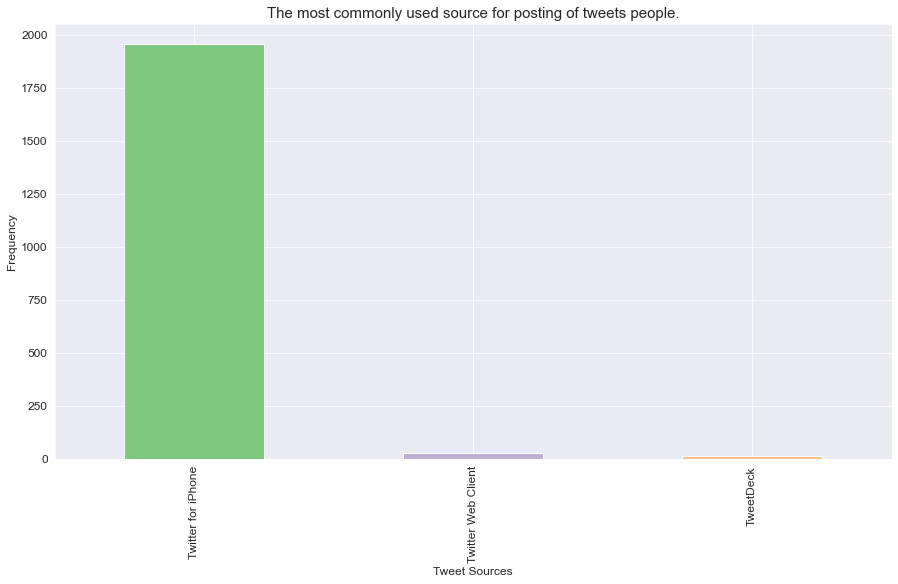

In [85]:
# create a plot diagram which is a bar chart by using plot function for "Frequency vs  Tweet Source".
source_tweets.plot(kind = 'bar', color = sns.color_palette("Accent"), figsize = (15,8), fontsize = 12)
# setup the title of the plot.
plt.title("The most commonly used source for posting of tweets people.",fontsize = 15)
# setup the x and y labels of the plot.
plt.xlabel("Tweet Sources",fontsize = 12)
plt.ylabel('Frequency',fontsize = 12)
# save figure
plt.savefig('img/most_used_source.png');

*The most commonly three used sources for posting of tweets people. First, it's "Twitter for iPhone' with 1955 counts, followed by "Twitter Web Client" with 28 counts, and "TweetDeck" with 11 counts.*

**- Which are the most famous dog names?**

In [86]:
name_count = df_master.name.value_counts()[1:]
famous_names = name_count.index.tolist()
name_count.head(10)

Charlie    11
Cooper     10
Lucy       10
Oliver     10
Tucker      9
Penny       9
Sadie       8
Winston     8
the         7
Daisy       7
Name: name, dtype: int64

In [87]:
dog_mask = np.array(Image.open("img/dog-mask.jpeg"))

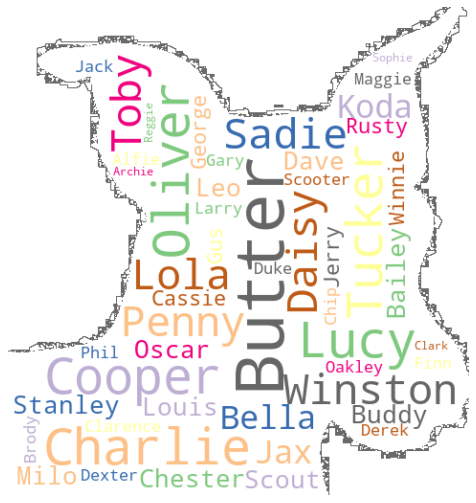

In [88]:
# Generate a wordcloud
wordcloud = WordCloud(background_color='white',
                     mask=dog_mask,
                     max_words=50,colormap='Accent',
                     max_font_size=70,
                     random_state=23,contour_width=1, contour_color='dimgrey'
                     ).generate(' '.join(famous_names))

# store to file
wordcloud.to_file("img/most_dog_names.png")

# show
plt.figure(figsize=[9,9])
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show();

*The most famous dog names were Charlie, Oliver, Lucy, Cooper, Tucker, Penny, Winston, Sadie, Toby, and Lola.*

**- How have the effects of retweets and favorites count changed over time?**

In [89]:
retweets_count = df_master.retweets.groupby([df_master['timestamp'].dt.year, df_master['timestamp'].dt.month]).mean()
favorites_count = df_master.favorites.groupby([df_master['timestamp'].dt.year, df_master['timestamp'].dt.month]).mean()

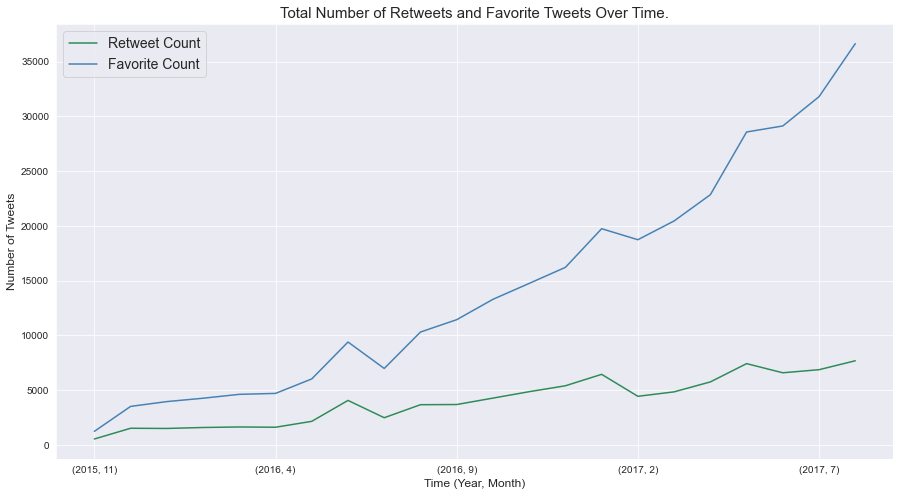

In [90]:
# Create a plot diagram which is line plot by using plot function for Time (Year, Month) and Number of Tweets.
# Figure size(width, height)
plt.figure(figsize = (15,8))
retweets_count.plot(kind='line',color = "seagreen")
favorites_count.plot(kind='line',color = "steelblue")

# Setup title of the line plot
plt.title('Total Number of Retweets and Favorite Tweets Over Time.', size =15)
# Setup x-axis label
plt.xlabel('Time (Year, Month)', fontsize = 12)
# Setup y-axis lable
plt.ylabel('Number of Tweets', fontsize = 12)
# Plotting the diagram
plt.legend(('Retweet Count', 'Favorite Count'), fontsize=14)
plt.savefig('img/retweet_favourite_count.png');
# View the line plot
plt.show() 

*The number of retweets and favorites has increased over time. Also, the number of likes was significantly more than the number of retweets. As it seems, in the year 2016 the number of likes and retweets decreased and then fluctuates over the months and years.*

**- Which are the most popular dog stages that people prefer?**

In [91]:
# Calculate sum of the favorites and retweets based on dog stages.
dog_favorites = df_master.groupby('dog_stage')['favorites'].sum().sort_values(ascending=False)[1:]
dog_retweets = df_master.groupby('dog_stage')['retweets'].sum().sort_values(ascending=False)[1:]

dog_prefer = df_master.groupby(['dog_stage'])["favorites", "retweets"].apply(lambda x : x.astype(int).sum())[1:]
dog_prefer

<ipython-input-91-0382cf44cced>:5: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  dog_prefer = df_master.groupby(['dog_stage'])["favorites", "retweets"].apply(lambda x : x.astype(int).sum())[1:]


,favorites,retweets
dog_stage,,
doggo,1219452,448919
"doggo, floofer",17169,3433
"doggo, pupper",112798,36751
"doggo, puppo",47844,19196
floofer,92442,34781
pupper,1461141,479807
puppo,474806,142427


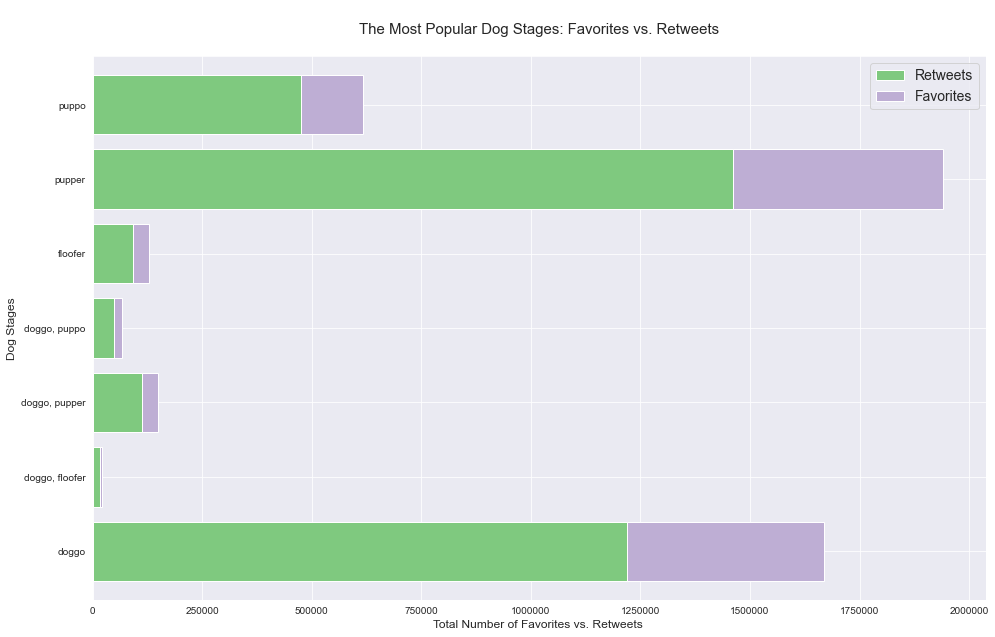

In [92]:
# Create a plot diagram which is bar plot 
# By using plot function for Dog Stages and Number of Favorites vs. Retweets.
dog_prefer.plot(figsize = (16,10), kind='barh',stacked=True, color = sns.color_palette("Accent"), width=0.8)


# Setup title of the line plot
plt.title('\nThe Most Popular Dog Stages: Favorites vs. Retweets\n', size =15)
# Setup x-axis label
plt.xlabel('Total Number of Favorites vs. Retweets ', fontsize = 12)
# Setup y-axis lable
plt.ylabel('Dog Stages', fontsize = 12)
# Setup legend label
plt.legend(('Retweets', 'Favorites'), fontsize=14)
ax = plt.gca()
ax.get_xaxis().get_major_formatter().set_scientific(False)
# Save the figure
plt.savefig('img/popular_dog_stages_prefer.png', dpi=100)
## View the line plot
plt.show()

*The most common dog breeds preferred by people were "pupper" and "doggo", they got the most number of retweets and likes. And, The "doggo,floofer" breeds has the fewest number of retweets and likes.*

**- Which stage of those popular dogs has the highest average rating?**

In [93]:
# Calculate mean rating for dog stages.
rate1 = df_clean.query('dog_stage == "pupper"').rating.mean()
rate2 = df_clean.query('dog_stage == "doggo"').rating.mean()
rate3 = df_clean.query('dog_stage == "puppo"').rating.mean()
rate4 = df_clean.query('dog_stage == "doggo, pupper"').rating.mean()
rate5 = df_clean.query('dog_stage == "floofer"').rating.mean()
rate6 = df_clean.query('dog_stage == "doggo, puppo"').rating.mean()
rate7 = df_clean.query('dog_stage == "doggo, floofer"').rating.mean()

In [94]:
# Store stages and rates in two arrays. 
stages = ['pupper', 'doggo', 'puppo', 'doggo, pupper', 'floofer', 'doggo, puppo','doggo, floofer']
rates = [rate1, rate2, rate3, rate4, rate5, rate6, rate7]
for x, y in zip(stages,rates):
    print(x + ":" , round(y, 2))

pupper: 1.06
doggo: 1.19
puppo: 1.2
doggo, pupper: 1.1
floofer: 1.2
doggo, puppo: 1.3
doggo, floofer: 1.1


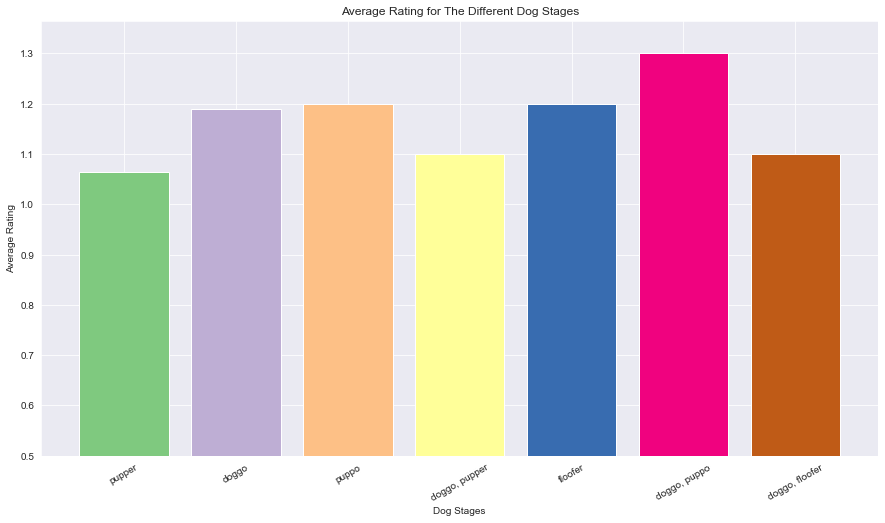

In [95]:
# Create a plot diagram which is bar plot 
# By using plot function for Dog Stages and Avarege Rating.
y_position = np.arange(len(stages))
plt.figure(figsize = (15,8))
plt.bar(y_position, rates, align='center', color = sns.color_palette("Accent"))

plt.xticks(y_position, stages)
plt.xticks(rotation=30)
plt.ylim(0.5,)
plt.xlabel('Dog Stages')
plt.ylabel("Average Rating")
plt.title("Average Rating for The Different Dog Stages")

plt.savefig('img/rating_dog_stages.png');
plt.show()

*The popular dog stage "doggo, puppo" has the highest average rating. Whereas dogs with the "pupper" stage the lowest average rating.*

**- What are the 10 most frequent predicted dog breeds?**

In [96]:
df_master['breed_prediction'].value_counts()[1:11].sort_values(ascending=False)

golden_retriever      158
labrador_retriever    108
pembroke               95
chihuahua              91
pug                    62
toy_poodle             51
chow                   48
samoyed                42
pomeranian             42
malamute               33
Name: breed_prediction, dtype: int64

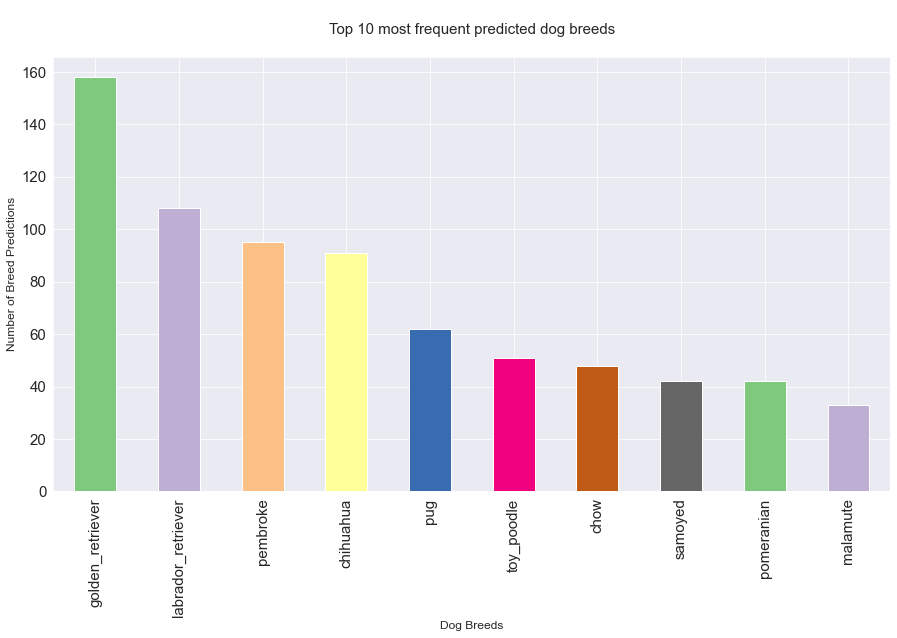

In [97]:
# Create a plot diagram which is bar plot 
# By using plot function for Dog Breeds and Top 10 frequent predicted.
# Figure size(width, height)
plt.figure(figsize = (15,8))
df_master['breed_prediction'].value_counts()[1:11].sort_values(ascending=False).plot(kind = 'bar',fontsize = 15, color = sns.color_palette("Accent"))

# Setup title of the line plot
plt.title('\nTop 10 most frequent predicted dog breeds\n', size=15)# Setup x-axis label
plt.xlabel('Dog Breeds', fontsize = 12)
# Setup y-axis lable
plt.ylabel('Number of Breed Predictions', fontsize = 12)
# Save the figure
plt.savefig('img/most_frequent_breeds.png', dpi=100)
## View the line plot
plt.show()

*The most frequent predicted dog breeds was golden_retriever with 158 predictios, followed by labrador_retriever with 108 predictios, pembroke got 95 predictions. Then, chihuahua with 91 predictions, followed by pug with 62 predictions, toy_poodle with 51 predictions, chow with 48 predictions, pomeranian with 42 predictions, samoyed with 42 predictions, and malamute with 33 predictions.*

<a id='conclusions'></a>
## Conclusion

In the final analysis, based on WeRateDogs Twitter data, which we gathered from the datasets, then we assessed and cleaned them. The data set was stored in a new file. Finally, worthwhile visualizations and analyzes of the data set were generated.

Furthermore,  the most commonly used source "Twitter for iPhone" with 1955 users, for posting of tweets. Also, the most famous dog names were Charlie, Oliver, and  Lucy. Moreover, the number of retweets and favourites has increased over time. And, the most dog breeds preferred by people were "pupper" and "doggo". Also, the "doggo, puppo" stage is the highest rated dog stage. Besides, the most frequent predicted dog breeds was golden_retriever with 158 predictios.